In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Classification Using CNN (first classify (potato))
By : Amira Fathy

________


Data link : https://www.kaggle.com/datasets/sadmansakibmahi/plant-disease-expert



In [ ]:
## import libraries


In [ ]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
import glob as gb
from zipfile import ZipFile

In [ ]:
# the path of zip file
file_name=r'/content/drive/MyDrive/Potato.zip'

In [ ]:
# extract zip file
with ZipFile(file_name,'r')as Zip:
  Zip.printdir()
  Zip.extractall()

In [ ]:
# path of image

data_path=r'/content/Potato'

In [ ]:
# get the common size in images
# and the number of the images in each folder
size = []
for folder in  os.listdir(data_path) :
    files = gb.glob(pathname= str( data_path +'/'+ folder + '/*.JPG'))
    print(f' found  {len(files)}  images in folder {folder}')
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

 found  1000  images in folder Potato___Early_blight
 found  152  images in folder Potato___healthy
 found  1000  images in folder Potato___Late_blight


(256, 256, 3)    2152
dtype: int64

In [ ]:
# initializing value
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [ ]:
# load images  by keras
dataset =tf.keras.preprocessing.image_dataset_from_directory(data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
# class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


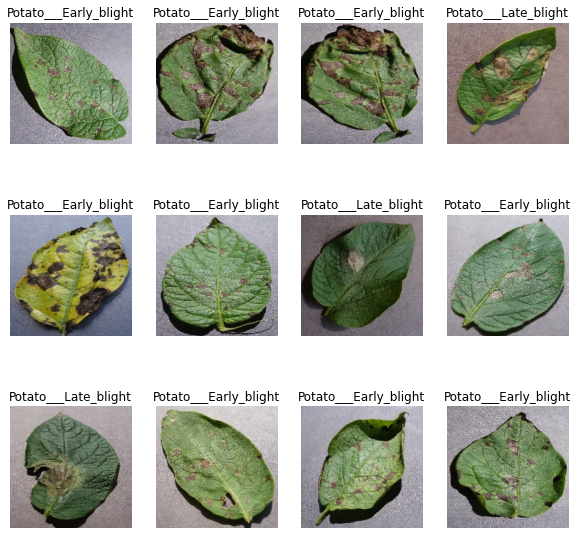

In [ ]:
# show some of image
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# len of  dataset
len(dataset)


68

In [ ]:
#  function to split data (train , test, validation)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
# split data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [ ]:
# to use the cpu & gpu
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

NameError: ignored

In [ ]:
# normalization data
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [ ]:
# data augmentation (ImageDataGenerator)
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
# bulid the CNN (Neural Network )
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#train CNN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 33s 472ms/step - loss: 0.9367 - accuracy: 0.4676 - val_loss: 0.8868 - val_accuracy: 0.6927
Epoch 2/30
54/54 [==============================] - 23s 431ms/step - loss: 0.7195 - accuracy: 0.7049 - val_loss: 0.5168 - val_accuracy: 0.7656
Epoch 3/30
54/54 [==============================] - 22s 412ms/step - loss: 0.3754 - accuracy: 0.8472 - val_loss: 0.3141 - val_accuracy: 0.8333
Epoch 4/30
54/54 [==============================] - 23s 425ms/step - loss: 0.3072 - accuracy: 0.8779 - val_loss: 0.3629 - val_accuracy: 0.8594
Epoch 5/30
54/54 [==============================] - 23s 423ms/step - loss: 0.2493 - accuracy: 0.8958 - val_loss: 0.2326 - val_accuracy: 0.9062
Epoch 6/30
54/54 [==============================] - 22s 412ms/step - loss: 0.2245 - accuracy: 0.9149 - val_loss: 0.2582 - val_accuracy: 0.8854
Epoch 7/30
54/54 [==============================] - 23s 426ms/step - loss: 0.2107 - accuracy: 0.9184 - val_loss: 0.1672 - val_accuracy: 0.9271

In [ ]:
# acuuracy of the test
scores = model.evaluate(test_ds)


8/8 [==============================] - 3s 134ms/step - loss: 0.0720 - accuracy: 0.9805


In [ ]:
scores


[0.07203318178653717, 0.98046875]

In [ ]:
history

In [ ]:
history.params


{'epochs': 30, 'steps': 54, 'verbose': 1}

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

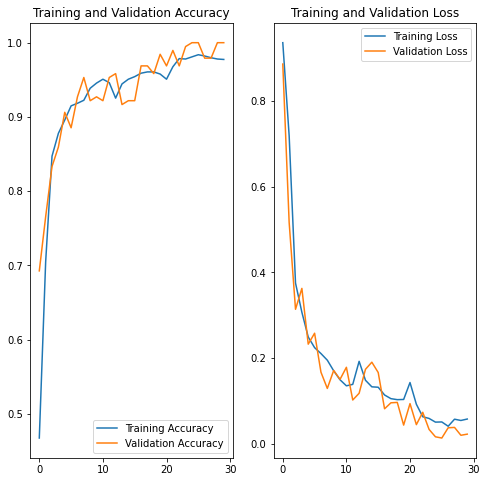

In [ ]:
# show the  training & validation (accuracy & loss)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


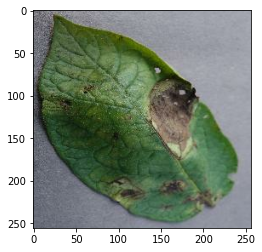

In [ ]:
# the first image prdiction  vs the actual
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

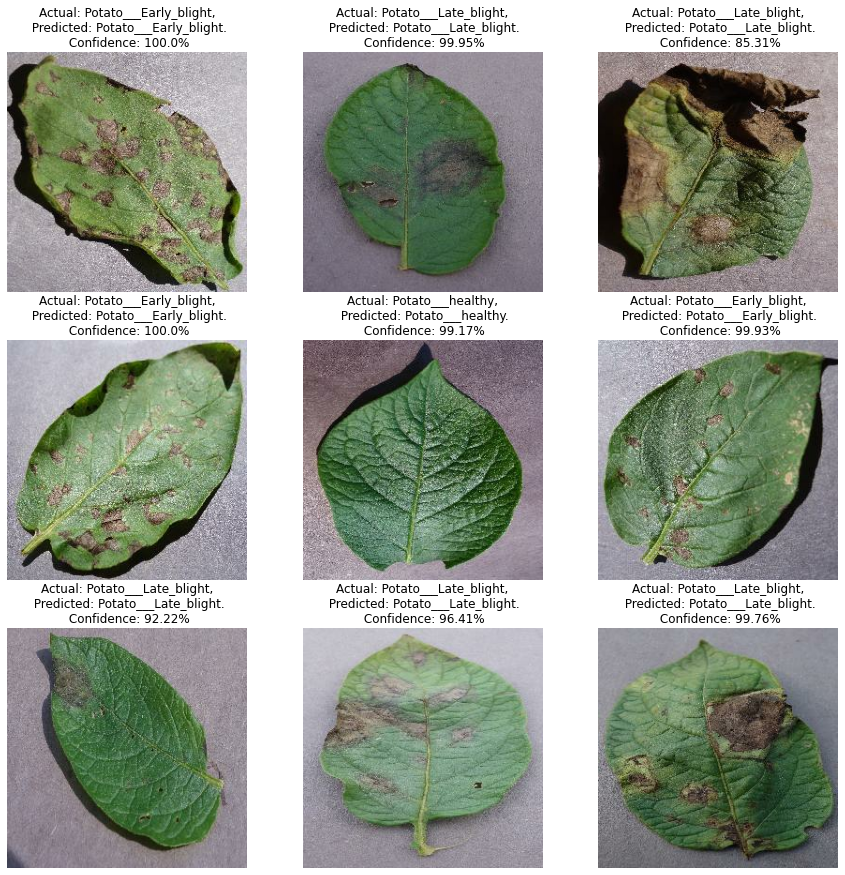

In [ ]:
# show some of image  ( the prediction  vs actual )& the confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
# save model
model.save("potato_cnn.h5")